In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [2]:
import os, random
# os.environ['TOKENIZERS_PARALLELISM']='false'

from tqdm import tqdm

import numpy as np
import pandas as pd

import datasets
from datasets import load_dataset, Image, load_metric, DatasetDict

import transformers
from transformers import Trainer, TrainingArguments
from transformers import ConvNextImageProcessor, AutoModelForImageClassification
from transformers import EarlyStoppingCallback 

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import matplotlib.pyplot as plt

import torch

import evaluate

In [3]:
SEED = 42

random.seed(SEED)
torch.manual_seed(SEED)

In [4]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
device

device(type='cuda')

In [6]:
from datasets import load_dataset

In [7]:
dataset = load_dataset('anurag2op/pcam-augmented-train-test-val-50k')

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [9]:
dataset = dataset.shuffle(seed=42)

In [10]:
train_ds = dataset['train']
test_ds = dataset['test']
val_ds = dataset['validation']

In [11]:
MODEL_CKPT='facebook/convnext-base-224-22k-1k'

NUM_OF_EPOCHS = 5

LEARNING_RATE=2e-4

STEPS=100

BATCH_SIZE = 16

In [12]:
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['non_tumor', 'tumor'], id=None)}

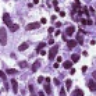

In [13]:
example = dataset["train"][2222]
example['image'] 

In [14]:
example['label']

1

In [15]:
def compute_metrics(p):
    accuracy_metric = evaluate.load("accuracy")
    accuracy = accuracy_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)['accuracy']
    
    ### ------------------- F1 scores -------------------
    
    f1_score_metric = evaluate.load("f1")
    weighted_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["f1"]
    micro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')['f1']
    macro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["f1"]
    
    ### ------------------- recall -------------------
    
    recall_metric = evaluate.load("recall")
    weighted_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["recall"]
    micro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')["recall"]
    macro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["recall"]
    
    ### ------------------- precision -------------------
    
    precision_metric = evaluate.load("precision")
    weighted_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["precision"]
    micro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')["precision"]
    macro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["precision"]
    
    return {"accuracy" : accuracy, 
            "Weighted F1" : weighted_f1_score,
            "Micro F1" : micro_f1_score,
            "Macro F1" : macro_f1_score,
            "Weighted Recall" : weighted_recall,
            "Micro Recall" : micro_recall,
            "Macro Recall" : macro_recall,
            "Weighted Precision" : weighted_precision,
            "Micro Precision" : micro_precision,
            "Macro Precision" : macro_precision
            }

In [16]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [17]:
id2label[0] , id2label[1] 

('non_tumor', 'tumor')

In [18]:
image_processor  = ConvNextImageProcessor.from_pretrained(MODEL_CKPT)

In [19]:
image_processor

ConvNextImageProcessor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "ConvNextFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

In [20]:
from torchvision.transforms import (
    Normalize,
    Compose,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
    
transforms = Compose(
        [
            Resize(image_processor.size['shortest_edge']),
            ToTensor(),
            normalize
        ]
    )

def preprocess(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    
    return example_batch


In [21]:
train_ds.set_transform(preprocess)
val_ds.set_transform(preprocess)
test_ds.set_transform(preprocess)

In [22]:
train_ds[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=96x96>,
 'label': 1,
 'pixel_values': tensor([[[-0.6623, -0.7137, -0.8849,  ...,  0.3481,  0.3481,  0.3481],
          [-0.6623, -0.7137, -0.8849,  ...,  0.3481,  0.3481,  0.3481],
          [-0.6623, -0.7137, -0.8849,  ...,  0.3481,  0.3481,  0.3481],
          ...,
          [ 0.8276,  0.7248,  0.4679,  ...,  0.2796,  0.2796,  0.2796],
          [ 0.5878,  0.4337, -0.0629,  ...,  0.4679,  0.4679,  0.4679],
          [ 0.5193,  0.3309, -0.2513,  ...,  0.5364,  0.5364,  0.5364]],
 
         [[-1.2654, -1.3179, -1.4930,  ..., -0.1800, -0.1800, -0.1800],
          [-1.2654, -1.3179, -1.4930,  ..., -0.1800, -0.1800, -0.1800],
          [-1.2654, -1.3179, -1.4930,  ..., -0.1800, -0.1800, -0.1800],
          ...,
          [ 0.3102,  0.2227, -0.0399,  ..., -0.2675, -0.2675, -0.2675],
          [-0.0399, -0.1975, -0.6877,  ..., -0.0924, -0.0924, -0.0924],
          [-0.1450, -0.3375, -0.8978,  ..., -0.0224, -0.0224, -0.0224]],
 


In [23]:
model = AutoModelForImageClassification.from_pretrained(
    MODEL_CKPT,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
).to(device)

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-base-224-22k-1k and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
model_name = MODEL_CKPT.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_OF_EPOCHS,
    weight_decay=0.01,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir='./logs'
)

In [25]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [26]:
early_stopping = EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.01)

In [27]:
trainer = Trainer(
    model,
    args,
    train_dataset = train_ds,
    eval_dataset = val_ds,
    tokenizer = image_processor,
    compute_metrics = compute_metrics,
    data_collator = collate_fn,
    callbacks=[early_stopping]
    
)

In [28]:
train_results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Weighted f1,Micro f1,Macro f1,Weighted recall,Micro recall,Macro recall,Weighted precision,Micro precision,Macro precision
1,0.307600,0.240313,0.900900,0.900877,0.900900,0.900877,0.900900,0.900900,0.900900,0.901266,0.900900,0.901266
2,0.246100,0.477811,0.870000,0.868378,0.870000,0.868378,0.870000,0.870000,0.870000,0.889180,0.870000,0.889180
3,0.010200,0.303019,0.923700,0.923533,0.923700,0.923533,0.923700,0.923700,0.923700,0.927429,0.923700,0.927429
4,0.000100,0.430920,0.931700,0.931699,0.931700,0.931699,0.931700,0.931700,0.931700,0.931721,0.931700,0.931721
5,0.000000,0.470210,0.937100,0.937093,0.937100,0.937093,0.937100,0.937100,0.937100,0.937286,0.937100,0.937286


In [29]:
trainer.save_model()

In [30]:
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)

***** train metrics *****
  epoch                    =           5.0
  total_flos               = 11048616792GF
  train_loss               =        0.1281
  train_runtime            =    1:52:42.35
  train_samples_per_second =        22.182
  train_steps_per_second   =         1.386


In [31]:
trainer.save_state()

In [32]:
metrics = trainer.evaluate(test_ds)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        5.0
  eval_Macro F1           =     0.9335
  eval_Macro Precision    =     0.9336
  eval_Macro Recall       =     0.9335
  eval_Micro F1           =     0.9335
  eval_Micro Precision    =     0.9335
  eval_Micro Recall       =     0.9335
  eval_Weighted F1        =     0.9335
  eval_Weighted Precision =     0.9336
  eval_Weighted Recall    =     0.9335
  eval_accuracy           =     0.9335
  eval_loss               =     0.5039
  eval_runtime            = 0:02:45.72
  eval_samples_per_second =     60.342
  eval_steps_per_second   =      3.771


In [33]:
predictions = trainer.predict(test_ds)

In [34]:
predictions[0]

array([[ 6.514452 , -6.5143914],
       [ 6.4064403, -6.4063935],
       [ 5.192208 , -5.1921453],
       ...,
       [ 4.509867 , -4.509822 ],
       [ 5.664172 , -5.6641088],
       [-5.887316 ,  5.8871613]], dtype=float32)

In [35]:
y_pred = np.argmax(predictions[0],axis=1)

In [36]:
y_pred

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [37]:
y_pred.shape

(10000,)

In [38]:
y_test = []

for i,j in enumerate(test_ds):
    y_test.append(test_ds[i]['label'])

In [39]:
y_test = np.array(y_test)

In [40]:
y_test

array([0, 0, 0, ..., 0, 0, 1])

In [41]:
y_test.shape

(10000,)

In [42]:
print(confusion_matrix(y_test,y_pred))

[[4708  292]
 [ 373 4627]]


In [43]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      5000
           1       0.94      0.93      0.93      5000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



In [44]:
target_classes=[]

label_map = { 0 :'non_tumor', 1:"tumor"}


for i in label_map.values():
    target_classes.append(i) 

In [45]:
target_classes

['non_tumor', 'tumor']

In [ ]:
ax = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,y_pred), display_labels=target_classes)
ax.plot()
plt.savefig('convnext.png',format= 'png')
plt.show()

In [46]:
repo_name = "convnext-base-224-22k-1k-pcam-finetuned"

model.push_to_hub(repo_name)
image_processor.push_to_hub(repo_name)

model.safetensors:   0%|          | 0.00/350M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/anurag2op/convnext-base-224-22k-1k-pcam-finetuned/commit/bbec0c3d0ecf350629f029b10caaa98b00401a43', commit_message='Upload processor', commit_description='', oid='bbec0c3d0ecf350629f029b10caaa98b00401a43', pr_url=None, pr_revision=None, pr_num=None)